# EVALUACIÓN DE ETIQUETADORES MORFOSINTÁCTICOS PARA EL ESPAÑOL
### Lingüística Computacional

#### Autor: Luis Cardoza Bird

### TAREA 1

Evaluación del etiquetador ‘hmm’ sobre el corpus ‘cess-esp’ utilizando el juego de categorías completo y reducido.

Utilizando el etiquetador hmm basado en modelos de Markov, se realizará una validación cruzada sobre 10 particiones del corpus. Barajar el corpus antes de realizar las particiones. Presentar los resultados en forma de tabla y gráficamente, incluyendo los intervalos de confianza.

In [40]:
import nltk
nltk.download('cess_esp')
from nltk.corpus import cess_esp
from random import shuffle
import itertools
from numpy import sqrt
from nltk.tag import hmm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.tag import AffixTagger
from nltk.tag import tnt
!pip install python-crfsuite
from nltk.tag import (UnigramTagger, BigramTagger, TrigramTagger,
                      CRFTagger, tnt, hmm, brill, brill_trainer, PerceptronTagger)
import pycrfsuite


[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


In [4]:
# Convert the corpus sentences to a list and then shuffle them
corpus_sentences = list(cess_esp.tagged_sents())
shuffle(corpus_sentences)

# Process sentences
procesed_sentences = [
    [
        (word[0], word[1][:3] if word[1][0].lower() in ['v', 'f'] else word[1][:2])
        for word in sentence if "*0*" not in word[0]
    ]
    for sentence in corpus_sentences
]

# Preview the datasets
print(f"\nDataset preview: {corpus_sentences[0][:10]}")
print(f"\nDataset reduced preview: {procesed_sentences[0][:10]}")
print(f"\nOriginal dataset size: {len(corpus_sentences)}")
print(f"\nReduced dataset size: {len(procesed_sentences)}")



Dataset preview: [('Esa', 'dd0fs0'), ('íntima', 'aq0fs0'), ('necesidad', 'ncfs000'), ('de', 'sps00'), ('victoria', 'ncfs000'), ('ante', 'sps00'), ('el', 'da0ms0'), ('Gran_Adversario', 'np0000a'), ('condujo', 'vmis3s0'), ('a', 'sps00')]

Dataset reduced preview: [('Esa', 'dd'), ('íntima', 'aq'), ('necesidad', 'nc'), ('de', 'sp'), ('victoria', 'nc'), ('ante', 'sp'), ('el', 'da'), ('Gran_Adversario', 'np'), ('condujo', 'vmi'), ('a', 'sp')]

Original dataset size: 6030

Reduced dataset size: 6030


In [5]:
def split(a, n):
    k, m = divmod(len(a), n)
    return [a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n)]

In [6]:
partitions = 10

cross_val_data_orig = split(corpus_sentences, partitions)
cross_val_data_redu = split(procesed_sentences, partitions)

print("Original:", cross_val_data_orig[1][1][:5])
print("Reduced:", cross_val_data_redu[1][1][:5])


Original: [('En', 'sps00'), ('el', 'da0ms0'), ('curso', 'ncms000'), ('de', 'sps00'), ('una', 'di0fs0')]
Reduced: [('En', 'sp'), ('el', 'da'), ('curso', 'nc'), ('de', 'sp'), ('una', 'di')]


In [7]:
accs_hmm_orig = []
accs_hmm_redu = []
ic_hmm_orig = []
ic_hmm_redu = []

for i in range(partitions):
    cross_test_orig = cross_val_data_orig[i]
    cross_train_orig = [sentence for j in range(partitions) if i != j for sentence in cross_val_data_orig[j]]
    cross_test_redu = cross_val_data_redu[i]
    cross_train_redu = [sentence for j in range(partitions) if i != j for sentence in cross_val_data_redu[j]]

    num_words_train_orig = sum(len(sentence) for sentence in cross_train_orig)
    num_words_train_redu = sum(len(sentence) for sentence in cross_train_redu)
        # Train models
    hmm_tagger_orig = hmm.HiddenMarkovModelTagger.train(cross_train_orig)
    hmm_tagger_redu = hmm.HiddenMarkovModelTagger.train(cross_train_redu)

    # Evaluate models
    hmm_eval_orig = hmm_tagger_orig.accuracy(cross_test_orig)
    hmm_eval_redu = hmm_tagger_redu.accuracy(cross_test_redu)

    # Append accuracies
    accs_hmm_orig.append(hmm_eval_orig)
    accs_hmm_redu.append(hmm_eval_redu)

    # Compute confidence intervals and append
    def compute_confidence_interval(eval_score, num_words):
        return 1.96 * sqrt((eval_score * (1 - eval_score)) / num_words)

    ic_hmm_orig.append(compute_confidence_interval(hmm_eval_orig, num_words_train_orig))
    ic_hmm_redu.append(compute_confidence_interval(hmm_eval_redu, num_words_train_redu))

In [8]:
def plot_cv(results, ic, type):
    figure(figsize=(10, 8), dpi=80)
    plt.axis([-1, 10, 0.89, 0.94])
    plt.ylabel('Accuracy')
    plt.xlabel('Fold')
    plt.title(f"{partitions}-fold cross validation {type} dataset")
    plt.plot(range(partitions), results, 'ro')
    plt.errorbar(range(partitions), results, yerr=ic, linestyle='None')
    plt.show()

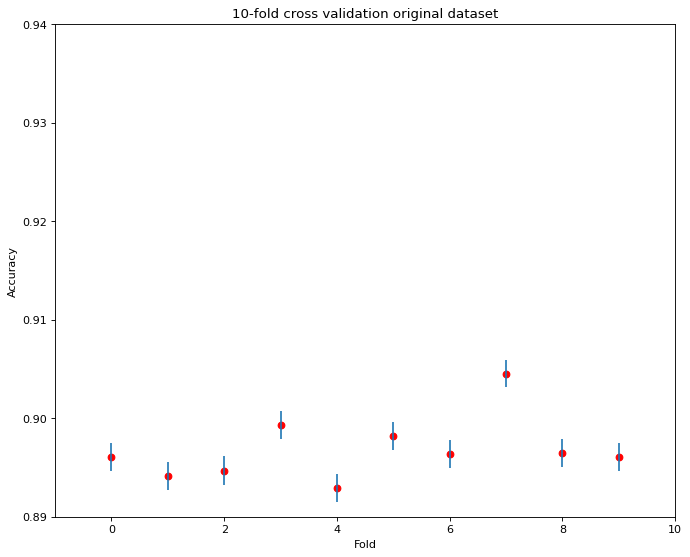

In [9]:
plot_cv( accs_hmm_orig, ic_hmm_orig, "original")

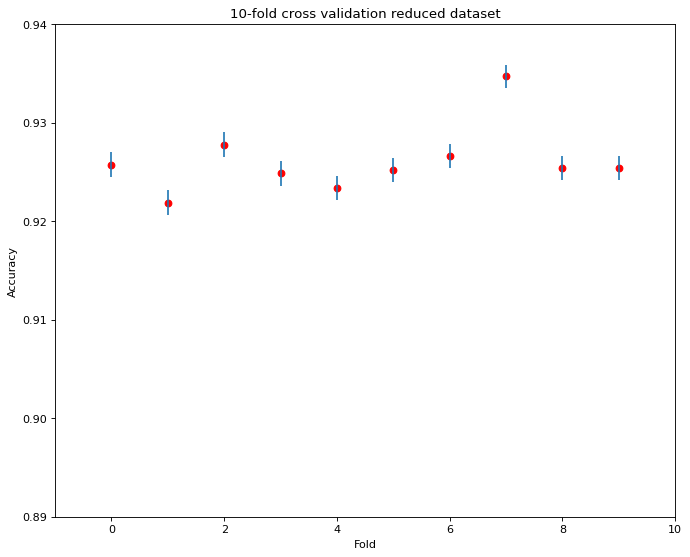

In [10]:
plot_cv( accs_hmm_redu, ic_hmm_redu, "reduced")

In [11]:
float_acc = 6

original_mean = sum(accs_hmm_orig) / len(accs_hmm_orig)
reduced_mean = sum(accs_hmm_redu) / len(accs_hmm_redu)

print(f"Original dataset avg: {original_mean:.{float_acc}f}")
print(f"Reduced dataset avg: {reduced_mean:.{float_acc}f}")

header = "\n\tFold \tacc_orig \tic_orig \tacc_redu \tic_redu"
print(header)
for i in range(partitions):
    print(f"\t{i} \t{accs_hmm_orig[i]:.{float_acc}f} \t±{ic_hmm_orig[i]:.{float_acc}f} \t{accs_hmm_redu[i]:.{float_acc}f} \t±{ic_hmm_redu[i]:.{float_acc}f}")


Original dataset avg: 0.896874
Reduced dataset avg: 0.926084

	Fold 	acc_orig 	ic_orig 	acc_redu 	ic_redu
	0 	0.896057 	±0.001439 	0.925727 	±0.001249
	1 	0.894130 	±0.001451 	0.921881 	±0.001278
	2 	0.894675 	±0.001442 	0.927767 	±0.001228
	3 	0.899356 	±0.001416 	0.924857 	±0.001253
	4 	0.892925 	±0.001454 	0.923357 	±0.001264
	5 	0.898159 	±0.001424 	0.925177 	±0.001251
	6 	0.896393 	±0.001436 	0.926630 	±0.001241
	7 	0.904505 	±0.001383 	0.934674 	±0.001175
	8 	0.896479 	±0.001433 	0.925379 	±0.001249
	9 	0.896063 	±0.001433 	0.925395 	±0.001247


### Tarea 2

Evaluación de las prestaciones del etiquetador respecto a la cantidad de datos de aprendizaje.

Se trata de estudiar cómo varían las prestaciones del etiquetador hmm cuando varía el tamaño del corpus de aprendizaje. Para este experimento se dividirá el corpus de entrenamiento en 10 partes de tamaño similar. La partición 10 se tomará como test, y las 9 particiones restantes se tomarán como entrenamiento. En cada ejecución, se irá incrementando sucesivamente el tamaño del corpus de entrenamiento, manteniendo fija la partición de test.

**Importante**: Para esta tarea **no es necesario** realizar la validación cruzada.

In [12]:
def train_model(train, test):
    num_words_train = sum(len(sentence) for sentence in train)

    # Train and evaluate the model
    hmm_tagger = hmm.HiddenMarkovModelTagger.train(train)
    hmm_eval = hmm_tagger.accuracy(test)

    # Compute confidence interval
    ic = 1.96 * sqrt((hmm_eval * (1 - hmm_eval)) / num_words_train)

    return hmm_eval, ic

In [13]:
results = []
ics = []

for i in range(partitions - 1):
    if i != 0:
        train = [sentence for j in range(i + 1) for sentence in cross_val_data_orig[j]]
    else:
        train = cross_val_data_orig[0]

    x, y = train_model(train, cross_val_data_orig[partitions - 1])
    results.append(x)
    ics.append(y)

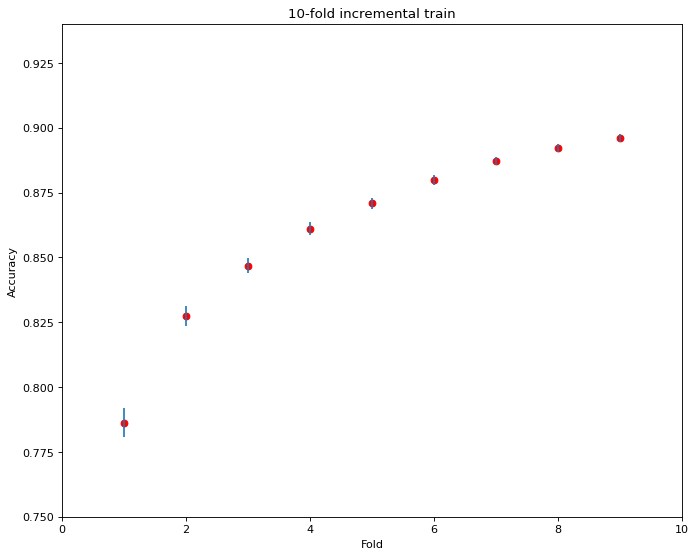

In [14]:
def plot_cv(results, ic):
    plt.figure(figsize=(10, 8), dpi=80)

    plt.axis([0, 10, 0.75, 0.94])
    plt.ylabel('Accuracy')
    plt.xlabel('Fold')
    plt.title(f"{partitions}-fold incremental train")

    plt.plot(range(1, partitions), results, 'ro')
    plt.errorbar(range(1, partitions), results, yerr=ic, linestyle='None')

    plt.show()

plot_cv(results, ics)

In [15]:
float_acc = 7

header = "\n\tFold \tAccuracies \tIC"
print(header)

for i in range(partitions - 1):
    print(f"\t{i} \t{results[i]:.{float_acc}f} \t±{ics[i]:.{float_acc}f}")


	Fold 	Accuracies 	IC
	0 	0.7862999 	±0.0056906
	1 	0.8274002 	±0.0037128
	2 	0.8468177 	±0.0029214
	3 	0.8610572 	±0.0024330
	4 	0.8708198 	±0.0021140
	5 	0.8798274 	±0.0018705
	6 	0.8872168 	±0.0016825
	7 	0.8923409 	±0.0015426
	8 	0.8960626 	±0.0014334


### Tarea 3

Evaluación del método de suavizado para palabras desconocidas para el etiquetador tnt.

El etiquetador tnt por defecto no incorpora un método de suavizado para las palabras desconocidas. Utiliza un método basado en los sufijos de las palabras para construir un modelo para las palabras desconocidas (Affix Tagger). En base al sufijo de la palabra desconocida le asigna una categoría morfosintáctica. Este método funciona razonablemente bien para el inglés.
En concreto, se trata de estudiar diferentes longitudes del sufijo (número de letras que se tienen en cuenta) y estudiar cómo varían las prestaciones del etiquetador. Una vez se haya decidido el sufijo que mejores prestaciones proporciona, incorporarlo como modelo de suavizado al etiquetador tnt y comprobar si aumenta sus prestaciones.

In [16]:
partition = 10
max_afix = 5

In [17]:
def train_affix_model(train, test, affix_length):
    num_words_train = sum(len(sentence) for sentence in train)

    # Train and evaluate the model
    aff_tagger = AffixTagger(train, affix_length=-affix_length)
    aff_eval = aff_tagger.accuracy(test)

    # Compute confidence interval
    ic = 1.96 * sqrt((aff_eval * (1 - aff_eval)) / num_words_train)

    return aff_eval, ic

In [18]:
results_dic = {}
ics_dic = {}

for affix_length in range(1, max_afix + 1):
    results = []
    ics = []

    for i in range(partition):
        test = cross_val_data_redu[i]
        train = [sentence for j in range(partitions) if i != j for sentence in cross_val_data_redu[j]]

        x, y = train_affix_model(train, test, affix_length)

        results.append(x)
        ics.append(y)

    results_dic[affix_length] = results
    ics_dic[affix_length] = ics

In [19]:
mean_affix_fold_error = [
    sum(results) / len(results) for affix_length, results in results_dic.items()
]

for affix_length, mean_error in zip(range(1, max_afix + 1), mean_affix_fold_error):
    print(f"Error medio para sufijos de tamaño {affix_length}: {mean_error}")

Error medio para sufijos de tamaño 1: 0.24472346135242157
Error medio para sufijos de tamaño 2: 0.28246309665195046
Error medio para sufijos de tamaño 3: 0.29552041950693864
Error medio para sufijos de tamaño 4: 0.2648479063546965
Error medio para sufijos de tamaño 5: 0.22537750936680534


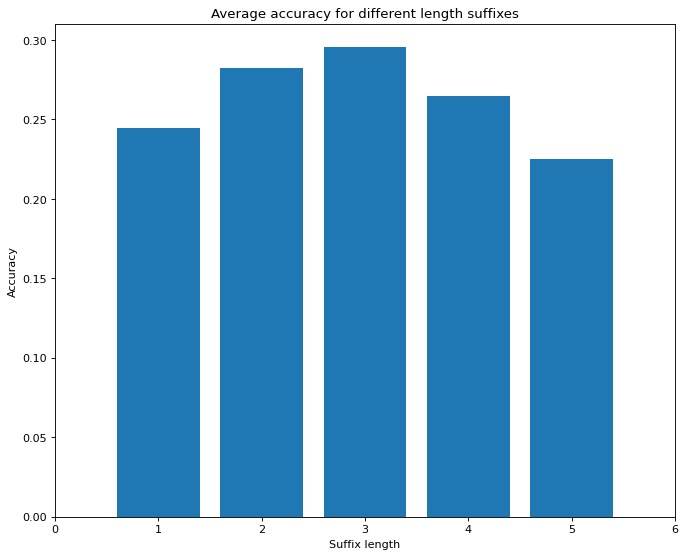

In [20]:
plt.figure(figsize=(10, 8), dpi=80)

x = range(1, max_afix + 1)
plt.axis([0, max_afix + 1, 0, .31])
plt.ylabel('Accuracy')
plt.xlabel('Suffix length')
plt.title('Average accuracy for different length suffixes')
plt.bar(x, mean_affix_fold_error)

plt.show()

In [21]:
def plot_affix(results, ic, affix_length):
    plt.figure(figsize=(10, 8), dpi=80)

    x = range(1, len(results) + 1)
    plt.axis([0, len(results) + 1, 0.27, 0.31])
    plt.ylabel('Accuracy')
    plt.xlabel('Fold')
    plt.title(f"{partitions}-fold train {affix_length} afix")

    plt.plot(x, results, 'ro')
    plt.errorbar(x, results, yerr=ic, linestyle='None')

    plt.show()


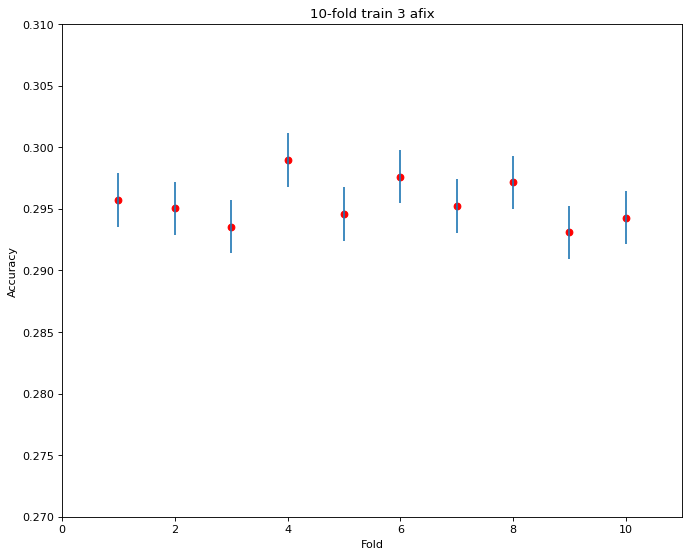

In [22]:
affix_length_to_plot = 3
plot_affix(results_dic[affix_length_to_plot], ics_dic[affix_length_to_plot], affix_length_to_plot)

In [23]:
def train_model_tnt(train, test, affix_length, enable_afix=True):
    num_words_train = sum(len(sentence) for sentence in train)

    aff_tagger = AffixTagger(train, affix_length=-affix_length) if enable_afix else None
    tnt_tagger = tnt.TnT(unk=aff_tagger, Trained=bool(aff_tagger))

    tnt_tagger.train(train)
    tnt_eval = tnt_tagger.accuracy(test)

    ic = 1.96 * sqrt((tnt_eval * (1 - tnt_eval)) / num_words_train)

    return tnt_eval, ic

In [24]:
results = []
ics = []

for i in range(partitions):
    test = cross_val_data_redu[i]
    train = [sentence for j in range(partitions) if i != j for sentence in cross_val_data_redu[j]]

    x, y = train_model_tnt(train, test, 3)

    results.append(x)
    ics.append(y)

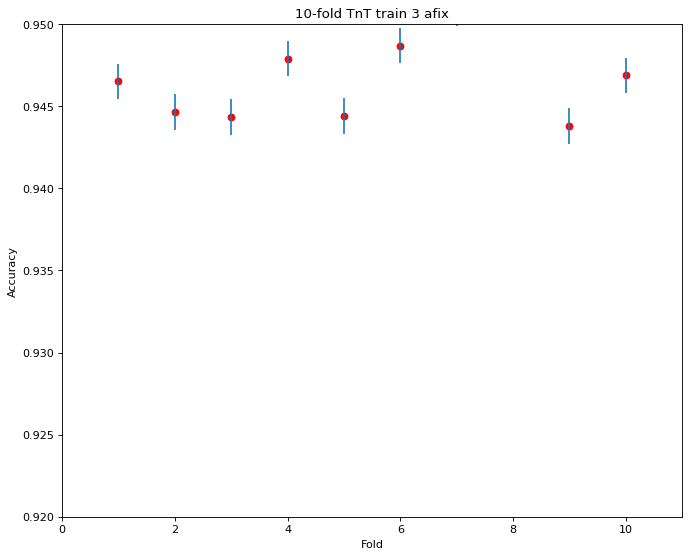

In [25]:
plt.figure(figsize=(10, 8), dpi=80)

x = range(1, len(results) + 1)
plt.axis([0, len(results) + 1, 0.92, .95])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title(f"{partitions}-fold TnT train 3 afix")

plt.plot(x, results, 'ro')
plt.errorbar(x, results, yerr=ics, linestyle='None')

plt.show()

In [26]:
results = []
ics = []

for i in range(partitions):
    test = cross_val_data_redu[i]
    train = [sentence for j in range(partitions) if i != j for sentence in cross_val_data_redu[j]]

    x, y = train_model_tnt(train, test, 0, False)

    results.append(x)
    ics.append(y)

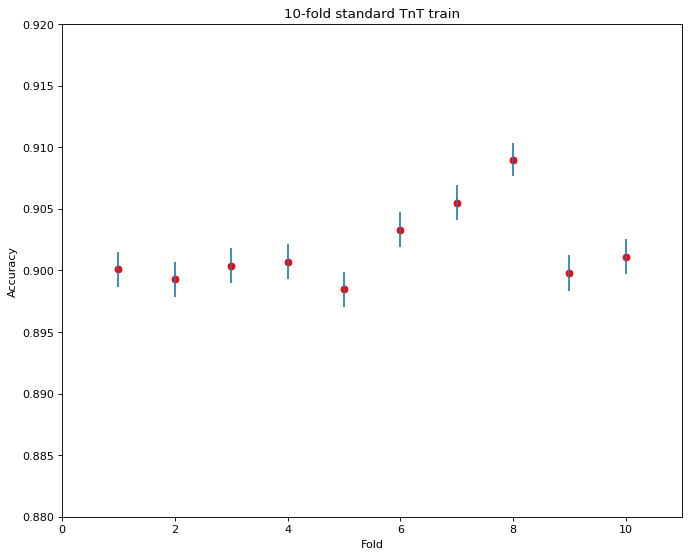

In [27]:
plt.figure(figsize=(10, 8), dpi=80)

x = range(1, len(results) + 1)
plt.axis([0, len(results) + 1, 0.88, .92])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title(f"{partitions}-fold standard TnT train")

plt.plot(x, results, 'ro')
plt.errorbar(x, results, yerr=ics, linestyle='None')

plt.show()

### Tarea 4

Evaluación del resto de etiquetadores.

Se deberán utilizar otros paradigmas de etiquetado. Como mínimo el etiquetador de Brill y algún otro como, CRF, perceptron. Se deberá realizar una comparativa de prestaciones respecto a los etiquetadores tnt y hmm, utilizando el juego de categorías reducido.
Cuando se utilice el etiquetador de Brill, probar con diferentes etiquetados iniciales, por ejemplo probar con Unigram Tagger y con hmm tagger.
La comparación puede ser sólo de una partición, si el coste temporal de la validación cruzada requiere mucho tiempo.

In [28]:
test = cross_val_data_redu[9]
train = [sentence for i in range(partitions-1) for sentence in cross_val_data_redu[i]]

print(train)

[[('Esa', 'dd'), ('íntima', 'aq'), ('necesidad', 'nc'), ('de', 'sp'), ('victoria', 'nc'), ('ante', 'sp'), ('el', 'da'), ('Gran_Adversario', 'np'), ('condujo', 'vmi'), ('a', 'sp'), ('un', 'di'), ('lleno', 'nc'), ('histórico', 'aq'), ('en', 'sp'), ('el', 'da'), ('Bernabéu', 'np'), ('y', 'cc'), ('a', 'sp'), ('un', 'di'), ('admirable', 'aq'), ('empeño', 'nc'), ('de', 'sp'), ('los', 'da'), ('madrileños', 'nc'), ('en', 'sp'), ('ganar', 'vmn'), ('el', 'da'), ('partido', 'nc'), ('.', 'Fp')], [('A_diferencia_de', 'sp'), ('hace', 'vmi'), ('dos', 'dn'), ('años', 'nc'), (',', 'Fc'), ('el', 'da'), ('Real_Madrid', 'np'), ('no', 'rn'), ('desplazará', 'vmi'), ('a', 'sp'), ('toda', 'di'), ('la', 'da'), ('plantilla', 'nc'), ('en', 'sp'), ('bloque', 'nc'), ('hasta', 'sp'), ('Tokio', 'np'), (',', 'Fc'), ('con_motivo_de', 'sp'), ('la', 'da'), ('Copa_Intercontinental', 'np'), ('.', 'Fp')], [('Una', 'di'), ('vez', 'nc'), ('finalizado', 'vmp'), ('el', 'da'), ('experimento', 'nc'), ('se', 'p0'), ('constataron'

In [29]:
# Brill with unigrams
unigram_tagger = UnigramTagger(train)

# Clearing existing templates and setting up new ones
brill.Template._cleartemplates()
templates = brill.brill24()

# Training the Brill tagger with a Unigram tagger as the initial tagger
brill_tagger_unigram = brill_trainer.BrillTaggerTrainer(unigram_tagger, templates).train(train)

# Evaluating the Brill tagger
brill_unigram_eval = brill_tagger_unigram.accuracy(test)

print(brill_unigram_eval)

0.8994985949639098


In [30]:
# Brill with bigrams
bigram_tagger = BigramTagger(train)

# Clearing existing templates and setting up new ones
brill.Template._cleartemplates()
templates = brill.brill24()

# Training the Brill tagger with a Bigram tagger as the initial tagger
brill_tagger_bigram = brill_trainer.BrillTaggerTrainer(bigram_tagger, templates).train(train)

# Evaluating the Brill tagger
brill_bigram_eval = brill_tagger_bigram.accuracy(test)

print(brill_bigram_eval)


0.7586092897680313


In [31]:
# Brill with trigrams
trigram_tagger = TrigramTagger(train)

# Clearing existing templates and setting up new ones
brill.Template._cleartemplates()
templates = brill.brill24()

# Training the Brill tagger with a Trigram tagger as the initial tagger
brill_tagger_trigram = brill_trainer.BrillTaggerTrainer(trigram_tagger, templates).train(train)

# Evaluating the Brill tagger
brill_trigram_eval = brill_tagger_trigram.accuracy(test)

print(brill_trigram_eval)


0.7535952394071299


In [32]:
# Brill with HMM
hmm_tagger = hmm.HiddenMarkovModelTagger.train(train)

# Clearing existing templates and setting up new ones
brill.Template._cleartemplates()
templates = brill.brill24()

# Training the Brill tagger with an HMM tagger as the initial tagger
brill_tagger_hmm = brill_trainer.BrillTaggerTrainer(hmm_tagger, templates).train(train)

# Evaluating the Brill tagger
brill_hmm_eval = brill_tagger_hmm.accuracy(test)

print(brill_hmm_eval)


0.9291421014931952


In [38]:
crf_tagger = CRFTagger()
crf_tagger.train(train, 'model.crf.tagger')
crf_eval = crf_tagger.evaluate(test)
print(crf_eval)


NameError: ignored

In [34]:
# Train and evaluate Perceptron tagger
perceptron_tagger = PerceptronTagger(load=False)
perceptron_tagger.train(train)
perceptron_eval = perceptron_tagger.accuracy(test)
print(perceptron_eval)


0.9688137087442834


In [35]:
from nltk.tag.hmm import HiddenMarkovModelTagger

# Train and evaluate HMM tagger
hmm_tagger = HiddenMarkovModelTagger.train(train)
hmm_eval = hmm_tagger.accuracy(test)
print(hmm_eval)


0.925395338586148


In [36]:
test = cross_val_data_redu[9]
train = [sentence for i in range(partitions-1) for sentence in cross_val_data_redu[i]]

# Train and evaluate TnT tagger
tnt_tagger = tnt.TnT()
tnt_tagger.train(train)
tnt_eval = tnt_tagger.accuracy(test)
print(tnt_eval)

0.9010964791448565


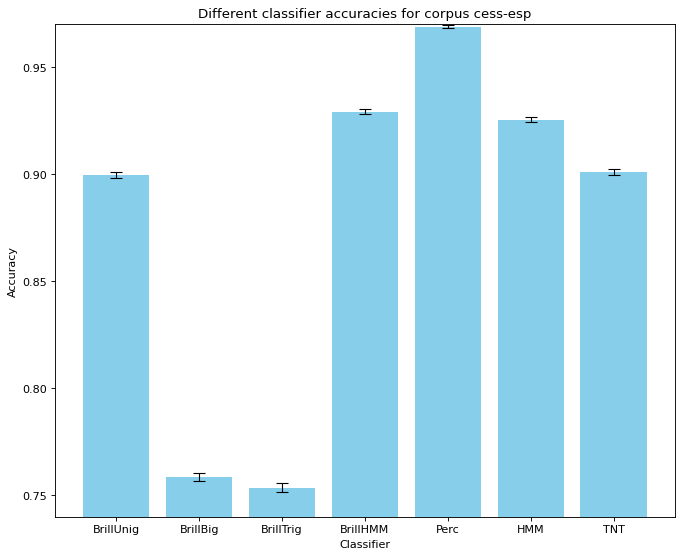

In [37]:
# Classifier names and their evaluations
clasificadores = ['BrillUnig', 'BrillBig', 'BrillTrig', 'BrillHMM', 'Perc', 'HMM', 'TNT']
evaluaciones = [brill_unigram_eval, brill_bigram_eval, brill_trigram_eval, brill_hmm_eval, perceptron_eval, hmm_eval, tnt_eval]

# Calculate total number of words in the training data
num_words_train = sum(len(sentence) for sentence in train)

# Calculate confidence intervals
ics = [1.96 * (sqrt((e * (1-e)) / num_words_train)) for e in evaluaciones]

# Plotting
plt.figure(figsize=(10, 8), dpi=80)
plt.bar(clasificadores, evaluaciones, yerr=ics, capsize=10, color='skyblue', error_kw=dict(lw=1, capsize=5, capthick=1))
plt.ylim(0.74, 0.97)
plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.title('Different classifier accuracies for corpus cess-esp')
plt.show()
